In [8]:
!pip install matplotlib requests pandas datetime bs4

  Using cached beautifulsoup4-4.14.2-py3-none-any.whl.metadata (3.8 kB)
  Using cached soupsieve-2.8-py3-none-any.whl.metadata (4.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [bs4]


In [15]:
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

def fetch_visa_bulletin(month, year):
    """Fetches the visa bulletin HTML content for the given month and year."""
    month_names = {1: "january", 2: "february", 3: "march", 4: "april", 5: "may", 6: "june", 
                   7: "july", 8: "august", 9: "september", 10: "october", 11: "november", 12: "december"}
    month_str = month_names[month]
    
    # Determine fiscal year based on month
    fiscal_year = year + 1 if month >= 10 else year
    
    url = f"https://travel.state.gov/content/travel/en/legal/visa-law0/visa-bulletin/{fiscal_year}/visa-bulletin-for-{month_str}-{year}.html"
    #
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        print(f"Failed to fetch {url}")
        return None

def convert_to_datetime(date_str, ref_date):
    """Converts date format from '15NOV22' to '11/15/22'. If 'C', returns last day of reference month."""
    if date_str in ["C", "U", "N/A"]:
        return ref_date.replace(day=1) + datetime.timedelta(days=31)
    try:
        return datetime.datetime.strptime(date_str, "%d%b%y")
    except ValueError:
        return None

def parse_tables(html_content, ref_date):
    """Extracts relevant data from the two tables containing 'Employment-based'."""
    soup = BeautifulSoup(html_content, 'html.parser')
    tables = [table for table in soup.find_all('table', {'border': '1'}) if "Employment-" in table.text]
    
    if len(tables) < 2:
        print("Could not find both required tables on the page.")
        return {}, {}
    
    def extract_data(table):
        data = {}
        rows = table.find_all('tr')
        for row in rows:
            cells = row.find_all('td')
            if cells and cells[0].text.strip() in ["3rd", "Other Workers"]:
                data[cells[0].text.strip()] = convert_to_datetime(cells[1].text.strip(), ref_date)
        return data
    
    return extract_data(tables[0]), extract_data(tables[1])

def get_visa_data(start_month, start_year, end_month, end_year):
    """Fetches and compiles visa bulletin data for the given date range."""
    global A_Final, B_Filing
    A_Final, B_Filing = pd.DataFrame(columns=['time', '3rd_date', 'other_date']), pd.DataFrame(columns=['time', '3rd_date', 'other_date'])
    
    current_date = datetime.datetime(start_year, start_month, 1)
    end_date = datetime.datetime(end_year, end_month, 1)
    
    while current_date <= end_date:
        html_content = fetch_visa_bulletin(current_date.month, current_date.year)
        if html_content:
            data_A, data_B = parse_tables(html_content, current_date)
            
            A_Final.loc[len(A_Final)] = [current_date.strftime('%m/%Y'), data_A.get("3rd", None), data_A.get("Other Workers", None)]
            B_Filing.loc[len(B_Filing)] = [current_date.strftime('%m/%Y'), data_B.get("3rd", None), data_B.get("Other Workers", None)]
        
        current_date += datetime.timedelta(days=32)
        current_date = current_date.replace(day=1)

def plot_graphs():
    """Generates line graphs for Final Action Dates and Filing Dates separately and combined."""
    # for df in [A_Final, B_Filing]:
    #     df['time'] = pd.to_datetime(df['time'], format='%m/%Y')
    #     df['3rd_date'] = pd.to_datetime(df['3rd_date'], errors='coerce')
    #     df['other_date'] = pd.to_datetime(df['other_date'], errors='coerce')
    
    # # Combined Graph
    # plt.figure(figsize=(12, 6))
    # plt.plot(A_Final['time'], A_Final['3rd_date'], marker='o', label='Final Action - 3rd', linestyle='-')
    # plt.plot(A_Final['time'], A_Final['other_date'], marker='s', label='Final Action - Other', linestyle='--')
    # plt.plot(B_Filing['time'], B_Filing['3rd_date'], marker='^', label='Filing Date - 3rd', linestyle='-')
    # plt.plot(B_Filing['time'], B_Filing['other_date'], marker='d', label='Filing Date - Other', linestyle='--')
    # plt.xlabel("Time")
    # plt.ylabel("Date")
    # plt.title("Visa Bulletin Trends - Combined")
    # plt.legend()
    # plt.grid()
    # plt.xticks(rotation=45)
    # plt.show()
    
    # Final Action Dates Graph
    plt.figure(figsize=(12, 6))
    plt.plot(A_Final['time'], A_Final['3rd_date'], marker='o', label='Final Action - 3rd', linestyle='-')
    plt.plot(A_Final['time'], A_Final['other_date'], marker='s', label='Final Action - Other', linestyle='--')
    plt.xlabel("Time")
    plt.ylabel("Date")
    plt.title("Final Action Dates")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()
    
    # Filing Dates Graph
    plt.figure(figsize=(12, 6))
    plt.plot(B_Filing['time'], B_Filing['3rd_date'], marker='^', label='Filing Date - 3rd', linestyle='-')
    plt.plot(B_Filing['time'], B_Filing['other_date'], marker='d', label='Filing Date - Other', linestyle='--')
    plt.xlabel("Time")
    plt.ylabel("Date")
    plt.title("Filing Dates")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()

def analyze_data():
    """Displays the fetched data and plots graphs."""
    # print("Table A - Final Action Dates")
    # print(A_Final.to_string(index=False, justify='center', col_space=12))
    # print("\nTable B - Filing Dates")
    # print(B_Filing.to_string(index=False, justify='center', col_space=12))
    plot_graphs()


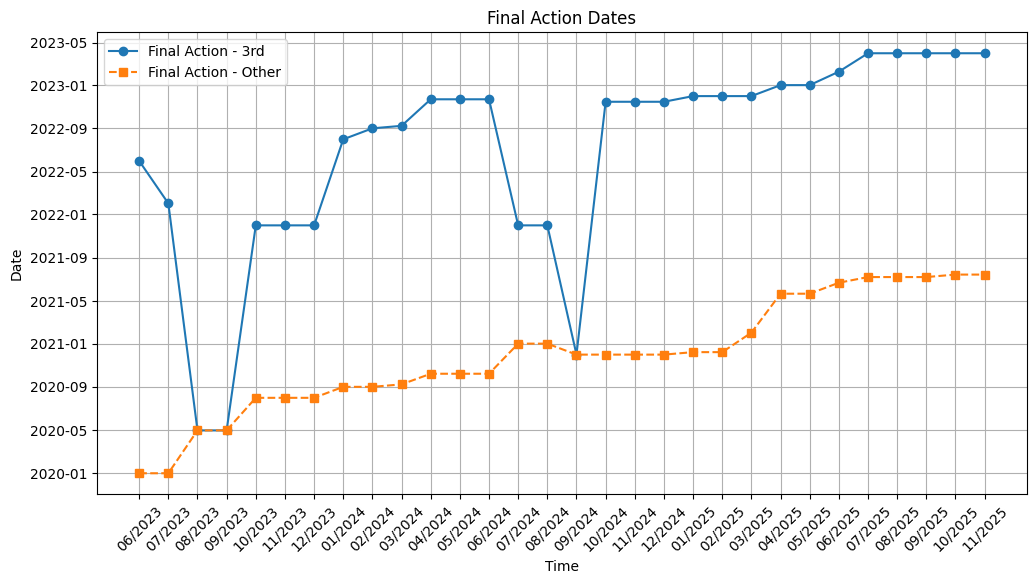

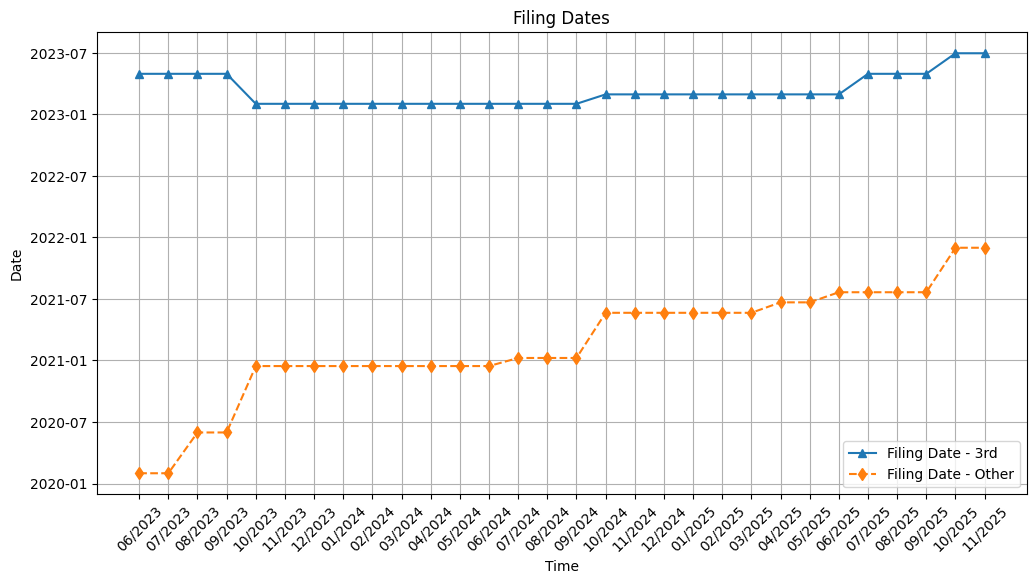

In [16]:

start_month, start_year = 6, 2023
end_month, end_year = 11, 2025
get_visa_data(start_month, start_year, end_month, end_year)
analyze_data()
